In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [97]:
project_id = "dh-global-sales-data-dev"
model_version_dict = {
    "AR": "5",
    "EG": "4",
    "PH": "5",
    "LA": "3",
    "MM": "4_1",
    "FI": "4",
    "HU": "4",
    "SA": "4"
}

In [101]:
project_id = "dh-global-sales-data-dev"
model_version_dict = {
    "EG": "4",
    "FI": "4",
}

In [102]:
def write_model_version_condition(country, version):
    model_version_=
    EXISTS (
    SELECT 1 
    FROM `dh-global-sales-data-dev.achilles.training_candidates_new` AS t2
    WHERE t2.country_iso = t1.country_iso
      AND t2.model_version = t1.model_version
      AND t2.country_iso = '{country}' 
      AND t2.model_version = '{version}'
    ) OR
    """
    return model_version_condition

final_model_version_condition = ""condition  f"""

for key, value in model_version_dict.items():
    model_version_condition = write_model_version_condition(key, value)
    final_model_version_condition += model_version_condition

final_model_version_condition = final_model_version_condition.strip() .strip("OR\n")

In [103]:
def write_model_version_condition(country, version):
    model_version_condition = f"""('{country}', '{version}'),"""
    return model_version_condition

final_model_version_condition = ""

for key, value in model_version_dict.items():
    model_version_condition = write_model_version_condition(key, value)
    final_model_version_condition += model_version_condition
final_model_version_condition = final_model_version_condition.strip(",")

In [104]:
final_model_version_condition

"('EG', '4'),('FI', '4')"

In [105]:
query = f"""
WITH labelled_data as(
    SELECT t1.*, `dh-global-sales-data.achilles.row_id_to_lead_id`(t1.left_row_id) AS left_lead_id, `dh-global-sales-data.achilles.row_id_to_lead_id`(t1.right_row_id) AS right_lead_id
    FROM `dh-global-sales-data-dev.achilles.training_candidates_new` AS t1
    WHERE (t1.country_iso, t1.model_version) IN ({final_model_version_condition})
    ORDER BY t1.country_iso, t1.model_version, t1.data_category_type
    )
SELECT labelled_data.*, vc1.restaurant_city as left_city, vc2.restaurant_city as right_city, vc1.main_cuisine as left_cuisine, vc2.main_cuisine as right_cuisine, vc1.price_level as left_price_level, vc2.price_level as right_price_level
FROM labelled_data
LEFT JOIN `dh-global-sales-data.leadgen_cl.vendor_complete` AS vc1 on labelled_data.left_lead_id = vc1.lead_id
LEFT JOIN `dh-global-sales-data.leadgen_cl.vendor_complete` AS vc2 on labelled_data.right_lead_id = vc2.lead_id
"""

df_training_candidates_new = pd.read_gbq(query=query, project_id = project_id, progress_bar_type = 'tqdm')

/var/folders/pt/q9f5cng91njf3hmhhhn0_7mr0000gq/T/ipykernel_19389/2919484560.py:14: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df_training_candidates_new = pd.read_gbq(query=query, project_id = project_id, progress_bar_type = 'tqdm')
/opt/homebrew/anaconda3/envs/embedding_experimentation/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2508: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


In [110]:
df_training_candidates_new["left_city"]=df_training_candidates_new["right_city"]
df_training_candidates_new["left_cuisine"]=df_training_candidates_new["right_cuisine"]

In [112]:
df_training_candidates_new.columns

Index(['country_iso', 'left_row_id', 'left_name', 'left_street', 'left_lat',
       'left_lng', 'left_phone_number', 'left_street_stop', 'left_name_stop',
       'left_name_stop_phonetic', 'left_street_stop_phonetic', 'right_row_id',
       'right_name', 'right_street', 'right_lat', 'right_lng',
       'right_phone_number', 'right_street_stop', 'right_name_stop',
       'right_name_stop_phonetic', 'right_street_stop_phonetic', 'haversine',
       'label', 'model_version', 'left_name_local', 'right_name_local',
       'left_name_local_transliterated', 'right_name_local_transliterated',
       'right_name_legal', 'model_id', 'col_type', 'left_registration_number',
       'right_registration_number', 'data_category_type', 'left_area',
       'right_area', 'left_lead_id', 'right_lead_id', 'left_city',
       'right_city', 'left_cuisine', 'right_cuisine', 'left_price_level',
       'right_price_level'],
      dtype='object')

In [116]:
def generate_vendor_document(name, name_local, cuisine, street, city):
    return f"""name: {name}, name_local: {name_local}, cuisine: {cuisine}, street: {street}, city: {city}"""

df_training_candidates_new["left_document"] = df_training_candidates_new.apply(lambda x: generate_vendor_document(x.left_name, x.left_name_local, x.left_cuisine, x.left_street, x.left_city), axis=1)
df_training_candidates_new["right_document"] = df_training_candidates_new.apply(lambda x: generate_vendor_document(x.right_name, x.right_name_local, x.right_cuisine, x.right_street, x.right_city), axis=1)

In [118]:
df_training_candidates_new["left_document"][0]

'name: pizza cartel vaasa, name_local: pizza cartel vaasa, cuisine: Pizza, street: pitkakatu, city: Vaasa'

In [119]:
df_training_candidates_new["right_document"][0]

'name: pizza cartel vaasa, name_local: pizza cartel vaasa, cuisine: Pizza, street: vasaesplanaden, city: Vaasa'

In [120]:
df_training_candidates_new[0:1]

country_iso                                        left_row_id  \
0          FI  PO_FI----dataweave---wolt---dd5e06e6-72db-41bb...   

            left_name left_street   left_lat   left_lng left_phone_number  \
0  pizza cartel vaasa   pitkakatu  63.095242  21.619263              None   

  left_street_stop      left_name_stop left_name_stop_phonetic  ...  \
0        pitkakatu  pizza cartel vaasa              PS KRTL FS  ...   

                           left_lead_id right_lead_id left_city right_city  \
0  dd5e06e6-72db-41bb-ac25-1b6f2ce7fed3        HWW0VB     Vaasa      Vaasa   

   left_cuisine  right_cuisine left_price_level right_price_level  \
0         Pizza          Pizza             None              None   

                                       left_document  \
0  name: pizza cartel vaasa, name_local: pizza ca...   

                                      right_document  
0  name: pizza cartel vaasa, name_local: pizza ca...  

[1 rows x 46 columns]

In [127]:
def generate_sentence_transformer_embeddings(documents):
    batch_size = 128
    embeddings = []
    model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
    for start_idx in tqdm(range(0, len(documents), batch_size)):
        end_idx = start_idx + batch_size
        batch = documents[start_idx:end_idx]
        embeddings_batch = model.encode(batch)
        embeddings.extend(embeddings_batch)
    return embeddings

In [148]:
left_documents = df_training_candidates_new["left_document"].values.tolist()
left_embeddings = generate_sentence_transformer_embeddings(left_documents)

100%|███████████████████████████████████████████| 37/37 [00:09<00:00,  3.76it/s]


In [149]:
right_documents = df_training_candidates_new["right_document"].values.tolist()
right_embeddings = generate_sentence_transformer_embeddings(right_documents)

100%|███████████████████████████████████████████| 37/37 [00:10<00:00,  3.45it/s]


In [150]:
len(left_embeddings)

4679

In [151]:
len(right_embeddings)

4679

In [155]:
df_training_candidates_new["left_embedding"] = left_embeddings
df_training_candidates_new["right_embedding"] = right_embeddings

In [173]:
df_training_candidates_new["embedding_cosine_similarity"] = df_training_candidates_new.apply(lambda x: cosine_similarity(x.left_embedding.reshape(1, -1), x.right_embedding.reshape(1, -1))[0][0], axis=1)

In [174]:
correlation=df_training_candidates_new[["label", "embedding_cosine_similarity"]].corr().iloc[0,1]
print(f"Correlation between embedding cosine similarity and actual matches: {correlation:.2f}")

Correlation between embedding cosine similarity and actual matches: 0.51


/var/folders/pt/q9f5cng91njf3hmhhhn0_7mr0000gq/T/ipykernel_19389/3532429302.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="embedding_cosine_similarity", data=df_training_candidates_new[["label", "embedding_cosine_similarity"]], palette="viridis")


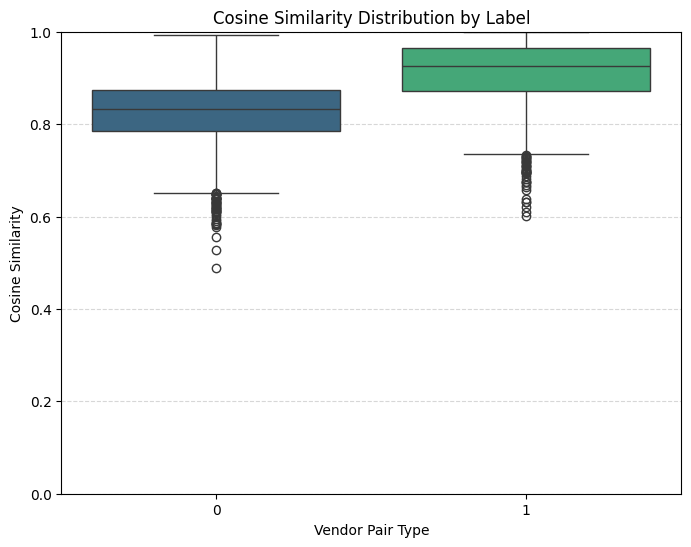

In [175]:
# Create boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x="label", y="embedding_cosine_similarity", data=df_training_candidates_new[["label", "embedding_cosine_similarity"]], palette="viridis")

# Add title and labels
plt.title("Cosine Similarity Distribution by Label")
plt.xlabel("Vendor Pair Type")
plt.ylabel("Cosine Similarity")
plt.ylim(0, 1)  # Set similarity range from 0 to 1
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Show plot
plt.show()

In [177]:
df_training_candidates_new.columns

Index(['country_iso', 'left_row_id', 'left_name', 'left_street', 'left_lat',
       'left_lng', 'left_phone_number', 'left_street_stop', 'left_name_stop',
       'left_name_stop_phonetic', 'left_street_stop_phonetic', 'right_row_id',
       'right_name', 'right_street', 'right_lat', 'right_lng',
       'right_phone_number', 'right_street_stop', 'right_name_stop',
       'right_name_stop_phonetic', 'right_street_stop_phonetic', 'haversine',
       'label', 'model_version', 'left_name_local', 'right_name_local',
       'left_name_local_transliterated', 'right_name_local_transliterated',
       'right_name_legal', 'model_id', 'col_type', 'left_registration_number',
       'right_registration_number', 'data_category_type', 'left_area',
       'right_area', 'left_lead_id', 'right_lead_id', 'left_city',
       'right_city', 'left_cuisine', 'right_cuisine', 'left_price_level',
       'right_price_level', 'left_document', 'right_document',
       'left_embedding', 'right_embedding', 'emedding_

In [192]:
df_embeddings_left = df_training_candidates_new[["country_iso", "left_lead_id", "left_name", "left_name_local", "left_cuisine", "left_street", "left_city", "left_embedding"]]
df_embeddings_left = df_embeddings_left.rename(columns={"left_lead_id": "lead_id", "left_name": "name", "left_name_local": "name_local", "left_cuisine": "cuisine", "left_street": "street",  "left_city": "city", "left_embedding": "embedding"})
df_embeddings_left["side"] = "left"

In [193]:
df_embeddings_right = df_training_candidates_new[["country_iso", "right_lead_id", "right_name", "right_name_local", "right_cuisine", "right_street", "right_city", "right_embedding"]]
df_embeddings_right = df_embeddings_right.rename(columns={"right_lead_id": "lead_id", "right_name": "name", "right_name_local": "name_local", "right_cuisine": "cuisine", "right_street": "street",  "right_city": "city", "right_embedding": "embedding"})
df_embeddings_right["side"] = "right"

In [195]:
df_embeddings_all = pd.concat([df_embeddings_left, df_embeddings_right], ignore_index=True)
df_embeddings_all = df_embeddings_all.drop_duplicates(subset=["lead_id"])

In [196]:
df_embeddings_all

country_iso                               lead_id  \
0             FI  dd5e06e6-72db-41bb-ac25-1b6f2ce7fed3   
1             FI  141ecde8-3e67-4c25-8512-c1a5db0e1997   
2             FI  f4c44bbd-6ec2-48b1-91b0-867cdeffbc9f   
3             FI  e97277e5-3005-4642-94b4-ba42b166143c   
4             FI  f89a2239-ef03-4e98-a58a-28581093b028   
...          ...                                   ...   
9353          EG                                HKX9WS   
9354          EG                                HKVCGL   
9355          EG                                HZN2V8   
9356          EG                                HZXE1U   
9357          EG                                HZWP52   

                                             name  \
0                              pizza cartel vaasa   
1                          runebergin pizza kebab   
2                               sushi house lohja   
3                         anchor bar wings - kemi   
4              päiviönsaari kiinalainen ravintola   
...                                           ...   
9353                               halawani shawl   
9354                               bashayer pizza   
9355                                 bazooka cafe   
9356  ali al charcoal restaurant not on the grill   
9357                                 beet el aela   

                              name_local           cuisine  \
0                     pizza cartel vaasa             Pizza   
1                 runebergin pizza kebab              None   
2                      sushi house lohja             Sushi   
3                anchor bar wings - kemi             Wings   
4     päiviönsaari kiinalainen ravintola           Chinese   
...                                  ...               ...   
9353                          حلواني شال    Cakes & Bakery   
9354                         بيتزا بشاير             Pizza   
9355                        بازوكا كافيه            Coffee   
9356        مطعم علي الفحم مش علي الجريل  Sandwiches;Grill   
9357                        beet el aela            Arabic   

                                                 street  \
0                                             pitkakatu   
1                                        runeberginkatu   
2                                           kalevagatan   
3                               this is a virtual venue   
4                                        ahlstrominkatu   
...                                                 ...   
9353  19 omar zafan al ibrahimeyah qebli wa al hadra...   
9354                                     al mohammedeya   
9355                   branched from gamal abd al naser   
9356                          branched from malak hefni   
9357                         mostafa mohammed ismail st   

                        city  \
0                      Vaasa   
1                   HELSINKI   
2                      Lohja   
3                       Kemi   
4                    Varkaus   
...                      ...   
9353  Alexandria Governorate   
9354  Alexandria Governorate   
9355  Alexandria Governorate   
9356  Alexandria Governorate   
9357  Alexandria Governorate   

                                              embedding   side  
0     [0.0020123373, 0.024084533, 0.08252737, 0.0737...   left  
1     [0.032029226, 0.022362785, 0.109583676, 0.1137...   left  
2     [0.34306583, -0.04732226, 0.116940916, 0.27118...   left  
3     [0.46692032, -0.18757388, 0.2456036, 0.0304455...   left  
4     [0.30965608, -0.12322949, 0.1740534, 0.1978650...   left  
...                                                 ...    ...  
9353  [0.3666319, 0.20736222, 0.08275185, 0.11432294...  right  
9354  [0.14817679, -0.03862984, 0.12138787, 0.028411...  right  
9355  [0.3061135, -0.0063069374, -0.065059215, 0.439...  right  
9356  [0.30310702, 0.07786217, 0.0022362834, 0.27644...  right  
9357  [0.35247302, 0.09507871, 0.251275, 0.06044571,...  right  

[7558 rows x 9 columns]

In [205]:
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(df_embeddings_all["embedding"].values.tolist())
df_embeddings_all["PCA_1"], df_embeddings_all["PCA_2"] = pca_embeddings[:, 0], pca_embeddings[:, 1]

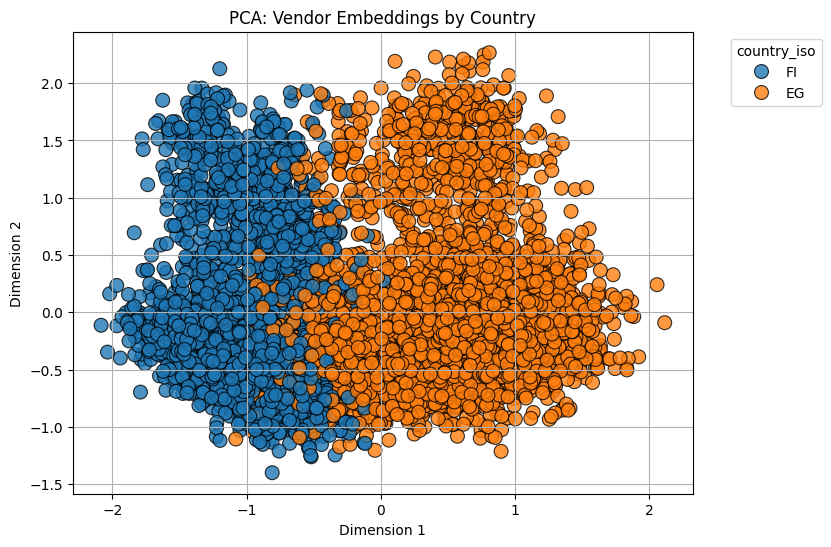

In [211]:
def plot_embeddings(x, y, data, hue, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=x, y=y, hue=hue, palette="tab10", data=data, s=100, alpha=0.8, edgecolors="black")
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.show()

# Plot PCA embeddings colored by City, Country, Cuisine
plot_embeddings("PCA_1", "PCA_2", df_embeddings_all, "country_iso", "PCA: Vendor Embeddings by Country")

/opt/homebrew/anaconda3/envs/embedding_experimentation/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26032 (\N{CJK UNIFIED IDEOGRAPH-65B0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/embedding_experimentation/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21271 (\N{CJK UNIFIED IDEOGRAPH-5317}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/embedding_experimentation/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


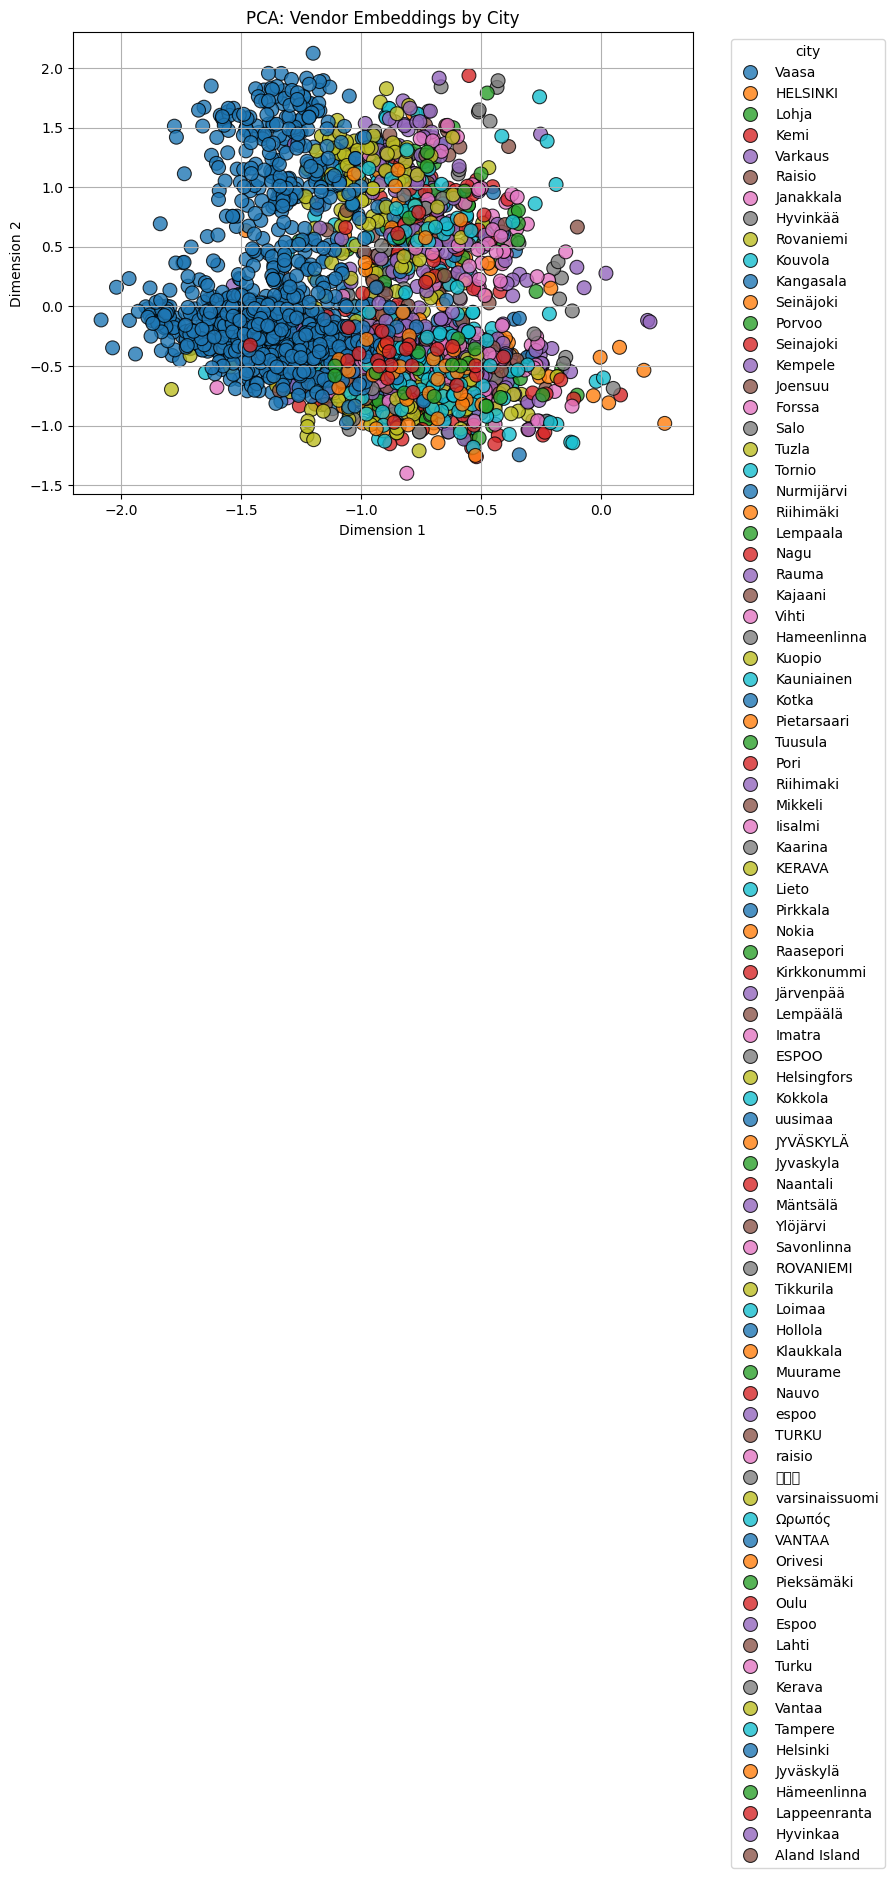

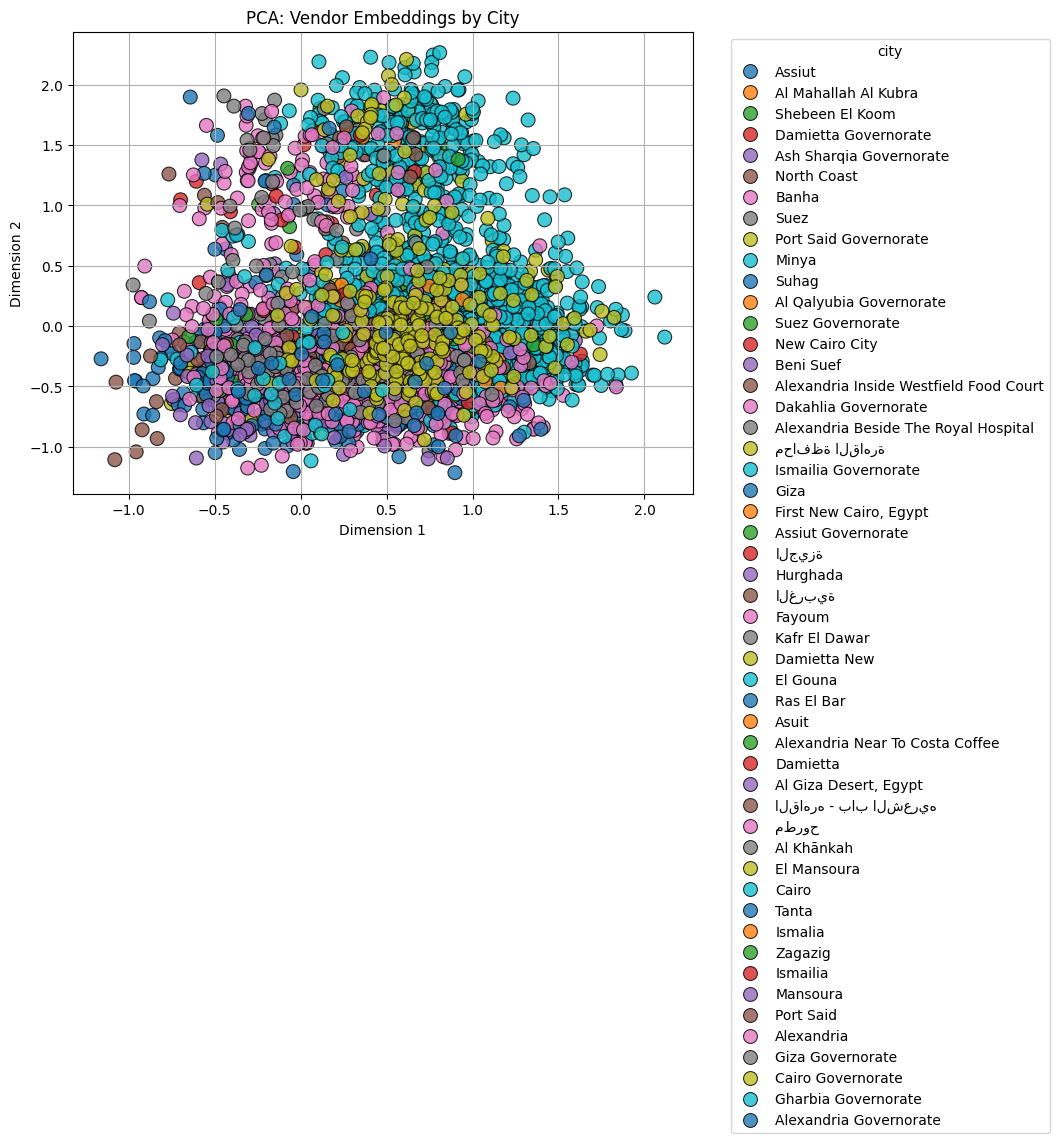

In [209]:
# Plot PCA embeddings colored by City per Country
plot_embeddings("PCA_1", "PCA_2", df_embeddings_all[df_embeddings_all["country_iso"]=="FI"], "city", "PCA: Vendor Embeddings by City")
plot_embeddings("PCA_1", "PCA_2", df_embeddings_all[df_embeddings_all["country_iso"]=="EG"], "city", "PCA: Vendor Embeddings by City")

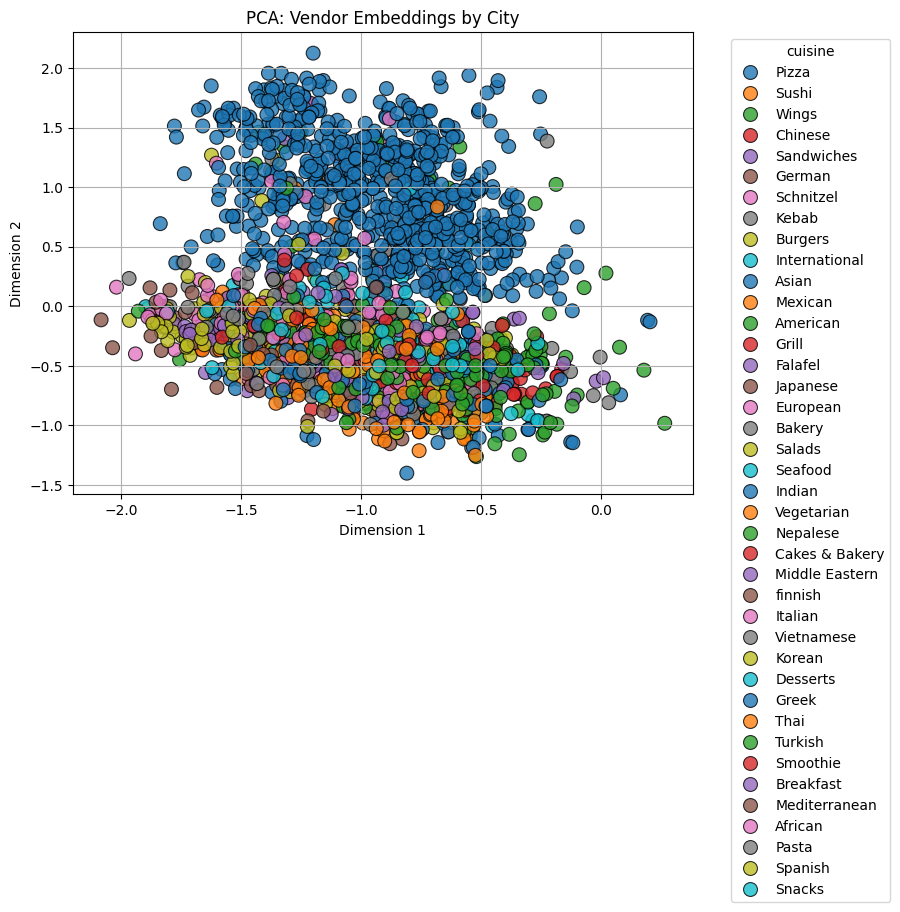

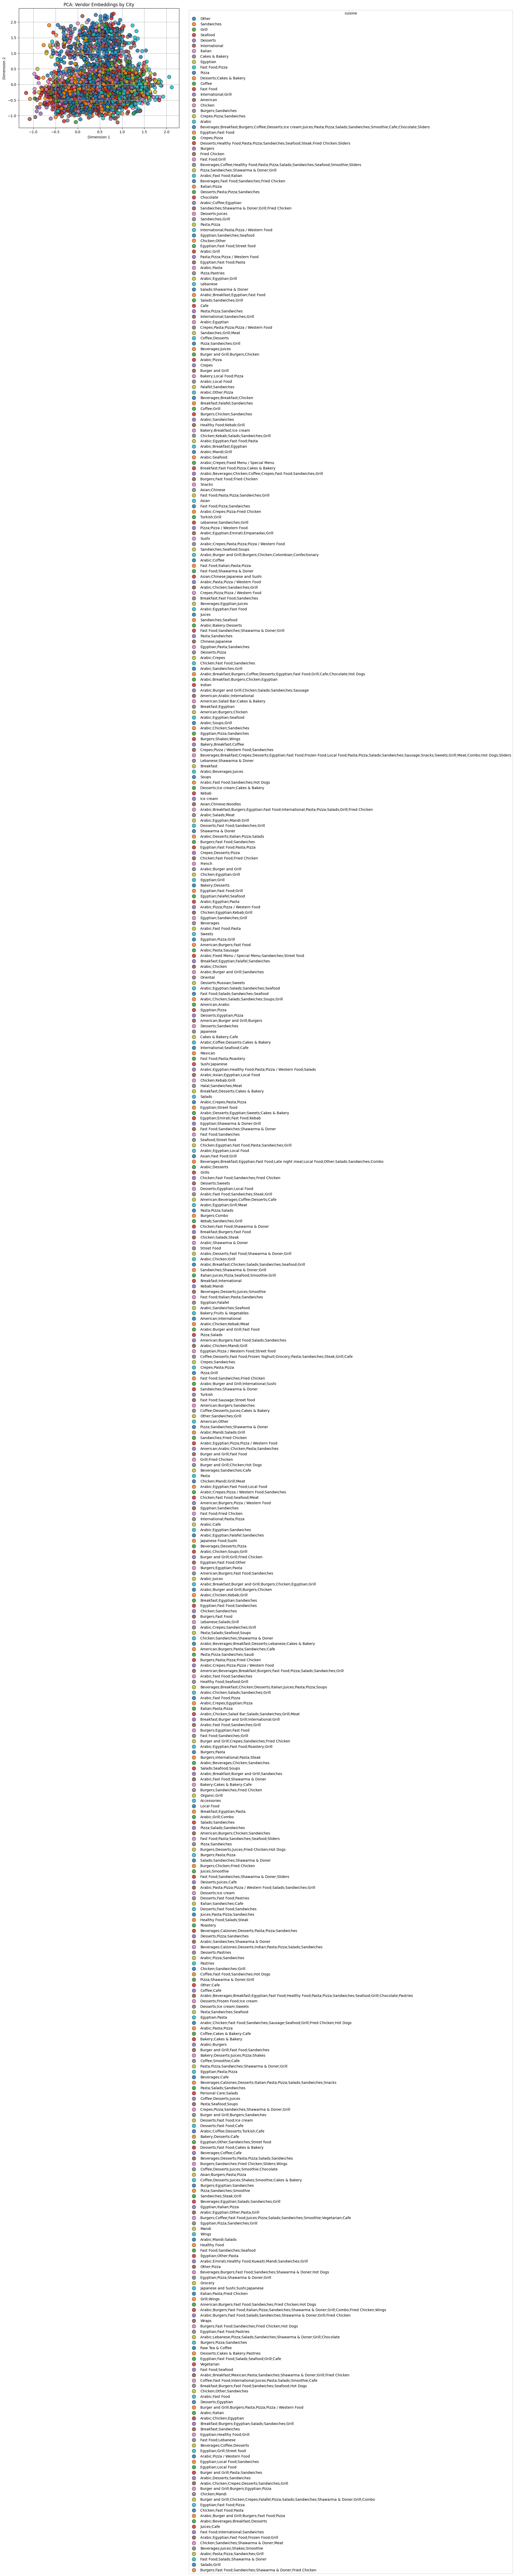

In [210]:
# Plot PCA embeddings colored by City per Country
plot_embeddings("PCA_1", "PCA_2", df_embeddings_all[df_embeddings_all["country_iso"]=="FI"], "cuisine", "PCA: Vendor Embeddings by City")
plot_embeddings("PCA_1", "PCA_2", df_embeddings_all[df_embeddings_all["country_iso"]=="EG"], "cuisine", "PCA: Vendor Embeddings by City")

Next steps:
-Formalize labels -> main city and cuisine groups for clustering
-Formalize additional metrics -> sillohuette score and other clustering quality metrics
-Nearest neighbors eval?
-Document findings